# The Bootstrap Analysis of Stable Clusters pipeline
This tutorial shows how to run a Bootstrap Analysis of Stable Clusters (BASC) pipeline using NIAK. 
  * **More documentation**: This tutorial only shows a limited subset of available options. See the [documentation](http://niak.simexp-lab.org/pipe_basc.html) of the pipeline for a more comprehensive list of options. 
  * **.m script**: The script of the tutorial can be downloaded [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/niak_tutorial_basc.m) and the notebook is available [here](https://nbviewer.jupyter.org/github/SIMEXP/niak_tutorials/blob/master/niak_tutorial_basc.ipynb).
  * **Pre-requisites**: before running this tutorial, you need to complete the [fMRI preprocessing tutorial](http://niak.simexp-lab.org/niak_tutorial_fmri_preprocessing.html). 
  * **Time for completion**: this tutorial will take approximetly 15 minutes to run. 

# Prepare input files

## fMRI

We will re-use the fMRI data that was generated during the fMRI preprocessing tutorial. The following instructions are going to "grab" these data. A few options are available to select subjects based on the level of motion, number of available volumes or run name. It is also possible to exclude subjects explicitely, e.g. if they failed visual quality control assessment. 

In [1]:
% Where to find data
clear
path_data = [pwd filesep];
path_preprocess = [path_data 'fmri_preprocess'];

% That option tells the grabber to prepare files for BASC
opt_g.type_files = 'rest'; 

% Minimum number of volumes per run - typically aim at 2 mns
% Shorther here because the test dataset is really small
opt_g.min_nb_vol = 20;

% Grab the "motor" run
opt_g.filter.run = {'motor'}; % Just grab the "motor" runs

% if uncommented, this option would exclude subject1
% opt_g.exclude_subject = {'subject1'};

% Grab the data
files_in = niak_grab_fmri_preprocess(path_preprocess,opt_g)

files_in =

  scalar structure containing the fields:

    data =

      scalar structure containing the fields:

        subject1 =

          scalar structure containing the fields:

            session1: 1x1 scalar struct

        subject2 =

          scalar structure containing the fields:

            session1: 1x1 scalar struct


    mask = /sandbox/home/git/niak_tutorials/fmri_preprocess/quality_control/group_coregistration/func_mask_group_stereonl.mnc.gz
    areas = /sandbox/home/git/niak_tutorials/fmri_preprocess/anat/template_aal.mnc.gz



# Set the options of the pipeline
Now we set up where to store the results:

In [2]:
% Where to store the results
opt.folder_out = [path_data 'basc_test_niak'];

This next parameter sets the size at which the region growing process stops (in mm$^3$). This does indirectly set the number of parcels covering the gray matter. A threshold of 1000 mm$^3$ will give about 1000 regions on the grey matter. Here we are going to reduce the dimension even more to speed up the pipeline.

In [3]:
% the size of the regions, when they stop growing. 
opt.region_growing.thre_size = 2000; 

The following parameter sets the values that will be explored regarding the number of clusters. A more exhaustive search, up to 500 clusters, could for example use an irregular grid like `[10:10:100 120:20:200 240:40:500]`. Also note that for each number of clusters, a number of solutions around those values, with different numbers being used at the individual and group levels, as well as the final consensus group partitions.  

In [4]:
% Search for stable clusters in the range 10 to 30
opt.grid_scales = [10:10:30]'; 

The following parameter is used to generate stability maps, and consensus partitions. Although stability is assessed over a wide range of parameters, those maps are only generated for select numbers in order to save disk space. For each set of results, three (integer) parameters actually need to be provided: the number of clusters at the individual level, at the group level and at the final consensus level. Each row will define a new set of results. We could for example use `opt.scales_maps = [10 10 10; 20 20 20];` to generate maps using the same number of clusters (5 and 10) at all three levels. For now we will leave that empty, which means we will not be generating any map. A first run of the pipeline is going to give us insights in the stable cluster solution, and provide data-driven suggestions about what number(s) of clusters to use. 

In [5]:
% Scale parameters to generate stability maps and consensus clusters
opt.scales_maps = [];

The following parameters control the number of bootstrap samples used to assess the stability of the clustering both at the individual level, and the group level. Note that with 100 samples, the confidence interval on the stability measures is $\pm 0.1$, while with 500 samples it reaches $\pm 0.05$. Here we will use only a few (20 samples) to speed-up the pipeline. 

In [6]:
% Number of bootstrap samples at the individual level.
opt.stability_tseries.nb_samps = 20;
% Number of bootstrap samples at the group level. 
opt.stability_group.nb_samps = 20; 

Also note that there is a minimal number of subjects for the group stability analysis to run. Because this demo has only two subjects, we will need to lower this parameter: 

In [7]:
opt.stability_group.min_subject = 2;

The final set of flags tell the pipeline which level of the pipeline to run. BASC can be used at the individual level, for each subject independently, or at the group level, to find a parcellation that is the consensus of those generated across all subjects and bootstrap replications of individual fMRI time series. In addition, BASC can generate so-called "mixed parcellation", which individual parcellations generated using the group parcellation as an initialization. It is possible to turn on/off the generation of consensus parcellations and stability map for each level of the pipeline (individual, group or mixed): 

In [8]:
% Generate maps/time series at the individual level
opt.flag_ind = false;   
% Generate maps/time series at the mixed level (group-level networks mixed with individual stability matrices).
opt.flag_mixed = false; 
% Generate maps/time series at the group level
opt.flag_group = true;  

# Running the pipeline

Now it is time to run the pipeline. As explained above, we will not at this stage generate any map or parcellation, but we will use the outputs to select the scales that we will explore in more details. The instruction to run the pipeline is: 

In [9]:
niak_pipeline_stability_rest(files_in,opt);


Logs will be stored in /sandbox/home/git/niak_tutorials/basc_test_niak/logs/
Generating dependencies ...
   Percentage completed :  0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100- 0.16 sec
Setting up the to-do list ...
All jobs are already completed. Bye for now !


Now that the pipeline has successfully completed, we can check a .csv file generated as part of the outpus. This .csv file list the number of clusters identified as "representative" of all stable solutions across the grid of clustering parameters we selected, using a method called MSTEPS. 

In [10]:
file_msteps = [opt.folder_out filesep 'stability_group' filesep 'msteps_group_table.csv'];
[tab,lx,ly] = niak_read_csv(file_msteps);
tab

tab =

   10    7    8
   10   12   11
   20   16   22
   20   24   27
   30   30   40



So each line is a number of clusters at the individual/group/consensus levels. Here MSTEPS has selected three scales as appropriate to summarize all tested numbers of clusters. Note that, even though we selected only 10, 20 and 30 in our grid, that grid is strictly used only at the individual level. At the group and consensus levels, other parameters are explored, in the neighbourhood of the number of individual clusters. We can now set these parameters in the pipeline to generate stability maps and parcellations:

In [11]:
opt.scales_maps = tab;

We can finally restart the pipeline. It will pick up where it left, and only deal with the generation of the maps. 

In [12]:
niak_pipeline_stability_rest(files_in,opt);


Logs will be stored in /sandbox/home/git/niak_tutorials/basc_test_niak/logs/
Generating dependencies ...
   Percentage completed :  0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100- 0.17 sec
Setting up the to-do list ...
All jobs are already completed. Bye for now !


The primary output of the BASC pipeline is a set of parcels for the selected pipeline. For example, the line `[10 7 8]` in opt.scales_maps means 10 individual clusters, 7 group clusters and 8 consensus (final) group clusters. Let's load and visualize that brain parcellation: 

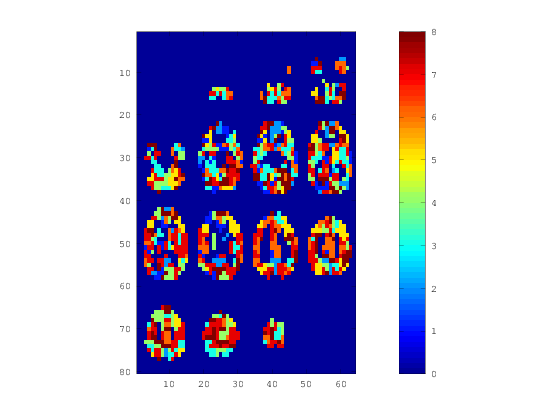

In [13]:
parcel_sc8 = [opt.folder_out filesep 'stability_group' filesep 'sci10_scg7_scf8' filesep 'brain_partition_consensus_group_sci10_scg7_scf8.mnc.gz'];
[hdr,sc8] = niak_read_vol(parcel_sc8);
niak_montage(sc8)

On this small dataset with big voxels, the parcellation does not look good. But that is enough to illustrate how to run the pipeline... Other (longer) tutorials will show how to explore the results on a dataset with smaller voxels and more subjects.  